In [19]:
%cd ..

/home/samuel.assis/MatchImm/MatchImmNet


In [21]:
from pyGeoMatchImm.data.datasets import TCRpMHCDataset, ChannelsPairDataset, ChannelsGraph
from pyGeoMatchImm.train.train import CrossValidator
from pyGeoMatchImm.models.models import (CrossAttentionGCN, 
                                         CrossAttentionGAT, 
                                         CrossAttentionGIN,
                                         CrossAttentionGATGIN, 
                                            MultiGCN,   
                                            MultiGAT,
                                            MultiGIN) 
from pyGeoMatchImm.utils.utils import validate_data
from pyGeoMatchImm.metrics.train_metrics import (plot_precision_recall_curve,
                                                 plot_roc_curve,
                                                 plot_loss_curve_logocv)

import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.functional import binary_cross_entropy_with_logits
from torch_geometric.data import Data, Batch
import os
import json
import logging as log

# logger
log.basicConfig(level=log.INFO)
log.getLogger("pyGeoMatchImm").setLevel(log.INFO)
log.getLogger("MDAnalysis").setLevel(log.WARNING)

In [24]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

map_cols = {
    'TCR_ID': 'id',
    'TRA_ref': 'TRA',
    'TRB_ref': 'TRB',
    'MHCseq_ref': 'MHCseq',
    'assigned_allele': 'mhc_allele',
    'peptide': 'epitope'
}

# Load Experimental Data
tcr3d_data_path = "data/02-processed/tcr3d_20251004_renamed.csv"
tcr3d_data = pd.read_csv(tcr3d_data_path, index_col=0)
tcr3d_data.drop(['TRA', 'TRB', 'MHCseq'], axis=1, inplace=True)
tcr3d_data.rename(columns=map_cols, inplace=True)
tcr3d_data.reset_index(drop=True, inplace=True)
print(tcr3d_data.head())

# Load AF Data
af_data_path = "data/01-raw/AF_vdjdb_score3_20251209.csv"
af_data = pd.read_csv(af_data_path)
af_data.rename(columns=map_cols, inplace=True)
af_data.reset_index(drop=True, inplace=True)
print(af_data.head())

# remove overlapping epitopes
tcr3d_data = tcr3d_data[~tcr3d_data['epitope'].isin(af_data['epitope'])]

train_data = pd.concat([tcr3d_data, af_data], ignore_index=True)
train_data = train_data.dropna(subset=['filepath_a', 'filepath_b'], how='any')

select_columns = ['id', 'TRA', 'TRB', 'CDR1A', 'CDR2A', 'CDR3A', 'CDR1B', 'CDR2B', 'CDR3B', 'TRA_num', 'TRB_num', 'epitope', 'MHCseq', 'mhc_allele', 'filepath_a', 'filepath_b', 'label', 'source']
train_data.drop_duplicates(subset=["TRA", "TRB", "epitope", "MHCseq"], inplace=True)
train_data = train_data[select_columns].head(30).copy()
train_data.to_csv("data/02-processed/tcrpMHC_combined_train_data.csv", index=False)


model_params = {
    "n_output": 1,
    "dropout": 0.3,
    "n_layers": 2
}

train_params = {
    "learning_rate"   : 0.0001,
    #"milestones"      : [1, 5],
    #"gamma"           : 0.5,
    "num_epochs"      : 60,
    "batch_size"      : 16,
    "pep_freq_range" : [0.005, 0.1],
    "k_top_peptides" : 10,
    "weight_decay"   : 0.01
}

config = {
    "source"          : "pdb",
    "channels"        : ["TCR", "pMHC"],
    "pairing_method"  : "basic",
    "embed_method"    : ["atchley"],
    "graph_method"    : "graphein",
    "negative_prop"   : 1,
    "edge_params"     : ["distance_threshold"],
    "node_params"     : ["amino_acid_one_hot", "hbond_donors", "hbond_acceptors", "dssp_config"],
    "graph_params"    : ["rsa"],
    "other_params"    : {"granularity": "centroids"},
    "dist_threshold"  : 8.0,
    "concat_embed"    : "all",
    "train_params"    : train_params,
    "model_params"    : model_params,
    "save_dir"        : ''
}

dataset = TCRpMHCDataset("data/02-processed/tcrpMHC_combined_train_data.csv", config=config)

models_dict = {
    "cagcn": CrossAttentionGCN,
    "cagat": CrossAttentionGAT,
    "cagin": CrossAttentionGIN,
    "cagatgin": CrossAttentionGATGIN,
    "multigcn": MultiGCN,
    "multigat": MultiGAT,
    "multigin": MultiGIN
}

embed = config['embed_method'][0]
arch = "cagin"

model_class = models_dict[arch]

log.info(f"Running architecture: {arch}")
log.info(f"Using embedding method: {embed}")

if embed == "atchley":
    config["train_params"]['norm'] = True
    config["train_params"]['out_channels'] = 16
else:
    config["train_params"]['norm'] = False
    config["train_params"]['out_channels'] = 128


save_dir = f"./{arch}_neg{config['negative_prop']}_{embed}_dp0{int(config['model_params']['dropout']*10)}"
config["save_dir"] = save_dir

channels = ChannelsGraph(dataset, config=config, embed_method=embed)
peptides = channels.get_seq_chain(name="pMHC", chain="C")


ds = ChannelsPairDataset(
        ids=channels.ids,
        ch1_graphs=channels.ch1,
        ch2_graphs=channels.ch2,
        labels=channels.get_labels(),   # or channels.y_tensor
        ch1_name=channels.channel_names[0],
        ch2_name=channels.channel_names[1],
    )

validate_data(train_data, dict_lists={
    "id": channels.ids,
    "epitope": peptides,
    "label": channels.get_labels(),
    "TRA": channels.get_seq_chain(name="TCR", chain="D"),
    "TRB": channels.get_seq_chain(name="TCR", chain="E")
},
    cols_to_check=["epitope", "label", "TRA", "TRB"])


INFO:pyGeoMatchImm.data.datasets:Creating Dataset...

INFO:pyGeoMatchImm.data.datasets:Number of samples: 30
INFO:pyGeoMatchImm.data.datasets:PDBDataset initialized
INFO:pyGeoMatchImm.data.datasets:
Creating dataset...

INFO:pyGeoMatchImm.data.datasets:Number of samples: 30
INFO:pyGeoMatchImm.data.datasets:Annotations:                                       {'TCR': {'TRA': 'D', 'TRB': 'E'}, 'pMHC': {'epitope': 'C', 'MHCseq': 'A'}}                      {'TCR': 'filepath_a', 'pMHC': 'filepath_b'}                           {'A': True, 'C': False, 'D': True, 'E': True}
INFO:pyGeoMatchImm.data.datasets:
Building Pairing samples based on channels...

INFO:pyGeoMatchImm.data.datasets:
Parsing structures...

INFO:pyGeoMatchImm.utils.utils:
Run function: <pyGeoMatchImm.data.parser.StructureParser object at 0x79185ecb7130>
INFO:pyGeoMatchImm.utils.utils:Using 25 CPU cores for multiprocessing.



Using device: cuda
        id      CDR1A          CDR2A           CDR3A    CDR1B  \
0  PDB8shi    YKTSINN   IRSNEREKHSGR    DALYSGGGADGL  QDMNHEY   
1  PDB4n5e   YSYSATPY  YYSGDPVVQGVNG       SAKGTGSKL  QTNSHNY   
2  PDB3kxf  YETRDTTYY  RNSFDEQNEISGR       SGFYNTDKL  QDMNHNS   
3  PDB8gvg   YSYGATPY  YFSGDTLVQGIKG       GFTGGGNKL  PISEHNR   
4  PDB4qrr  YETSWWSYY   QGSDEQNAKSGR  GELAGAGGTSYGKL  PISGHRS   

              CDR2B       CDR3B  \
0   SVGAGITDQGEVPNG   SYSEGEDEA   
1   SYGAGNLQIGDVPDG     SDAPGQL   
2   SASEGTTDKGEVPNG   PGLAGEYEQ   
3  FQNEAQLEKSRLLSDR  SDRDRVPETQ   
4   YFSETQRNKGNFPGR  SLEGGYYNEQ   

                                                 TRA  \
0  SQQGEEDPQALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHL...   
1  AQSVTQPDARVTVSEGASLQLRCKYSYSATPYLFWYVQYPRQGLQM...   
2  QKVTQAQTEISVVEDEDVTLDCVYETRDTTYYLFWYKQPPSGELVF...   
3  AQSVTQPDIHITVSEGASLELRCNYSYGATPYLFWYVQSPGQGLQL...   
4  KVTQAQSSVSMPVRKAVTLNCLYETSWWSYYIFWYKQLPSKEMIFL...   

                                          

INFO:pyGeoMatchImm.data.datasets:
Generating graphs using graphein...

INFO:pyGeoMatchImm.utils.utils:
Run function: <pyGeoMatchImm.data.generators.graphein.GrapheinGeneratorRes object at 0x79185ecb7040>
INFO:pyGeoMatchImm.utils.utils:Using 25 CPU cores for multiprocessing.

INFO:pyGeoMatchImm.data.datasets:
Generate negatives

INFO:pyGeoMatchImm.utils.negatives:Preparating data for chains Peptide chain C and  MHC chain A
INFO:pyGeoMatchImm.utils.negatives:Data: 30 positive samples.
INFO:pyGeoMatchImm.data.datasets:
Combining positives and negatives...

INFO:pyGeoMatchImm.data.datasets:Embedding sequences using Atchley factors...
INFO:pyGeoMatchImm.data.datasets:IDs: ['PDB4qrr_PDB8i5d', 'PDB6am5', 'PDB7jwi_PDB6rpa', 'PDB5nme', 'PDB4g8g', 'PDB3tjh', 'PDB7n5p_PDB7nmf', 'PDB6rpa_PDB3kxf', 'PDB5til_PDB6vmx', 'PDB7jwi', 'PDB5c0b', 'PDB4jfe_PDB7n4k', 'PDB2nx5_PDB8ryn', 'PDB8rym_PDB2e7l', 'PDB8i5d_PDB8rym', 'PDB8rym_PDB5nme', 'PDB8gvg', 'PDB4jfd', 'PDB2e7l_PDB6vrm', 'PDB4qrr', 'PDB4mxq', 'PDB

'Validation passed!'

INFO:pyGeoMatchImm.data.datasets:Graph details for sample PDB4qrr_PDB8i5d:
INFO:pyGeoMatchImm.data.datasets:Channels: ['TCR', 'pMHC']
INFO:pyGeoMatchImm.data.datasets:

--------------------------------------------------Channel TCR--------------------------------------------------


INFO:pyGeoMatchImm.data.datasets:  Node E:THR:67: {'chain_id': 'E', 'residue_name': 'THR', 'residue_number': 67, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 14.761572, -15.575857,  14.091857], dtype=float32), 'b_factor': 31.90999984741211, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 'hbond_donors': array([1]), 'hbond_acceptors': array([1]), 'rsa': 0.6126760563380281, 'atchley': tensor([-0.0320,  0.3260,  2.2130,  0.9080,  1.3130])}
INFO:pyGeoMatchImm.data.datasets:  Node D:ARG:57: {'chain_id': 'D', 'residue_name': 'ARG', 'residue_number': 57, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 8.854909 ,  9.208909 , 10.6893635], dtype=flo

['PDB4qrr_PDB8i5d', 'PDB6am5', 'PDB7jwi_PDB6rpa', 'PDB5nme', 'PDB4g8g', 'PDB3tjh', 'PDB7n5p_PDB7nmf', 'PDB6rpa_PDB3kxf', 'PDB5til_PDB6vmx', 'PDB7jwi', 'PDB5c0b', 'PDB4jfe_PDB7n4k', 'PDB2nx5_PDB8ryn', 'PDB8rym_PDB2e7l', 'PDB8i5d_PDB8rym', 'PDB8rym_PDB5nme', 'PDB8gvg', 'PDB4jfd', 'PDB2e7l_PDB6vrm', 'PDB4qrr', 'PDB4mxq', 'PDB6vrm', 'PDB8gvg_PDB4mxq', 'PDB8i5d', 'PDB3tjh_PDB7jwi', 'PDB8rym', 'PDB8shi', 'PDB8shi_PDB4g8g', 'PDB7n4k', 'PDB8qfy_PDB2nx5', 'PDB5til', 'PDB6vmx', 'PDB4g8g_PDB4jfd', 'PDB7n5p', 'PDB3tjh_PDB8qfy', 'PDB8qfy', 'PDB7nmf_PDB7n5p', 'PDB6vmx_PDB5til', 'PDB3tjh_PDB8shi', 'PDB2bnr_PDB4ms8', 'PDB2bnr', 'PDB6vrm_PDB4n5e', 'PDB5nme_PDB8gvg', 'PDB3kxf', 'PDB4jfe', 'PDB5c0a_PDB6am5', 'PDB7nmf', 'PDB3tjh_PDB4jfe', 'PDB7n5p_PDB5c0b', 'PDB4jfe_PDB5c0a', 'PDB6rpa', 'PDB6am5_PDB4qrr', 'PDB2nx5', 'PDB2e7l', 'PDB8ryn', 'PDB5c0a', 'PDB3kxf_PDB2bnr', 'PDB4n5e', 'PDB4ms8', 'PDB5c0a_PDB3tjh']


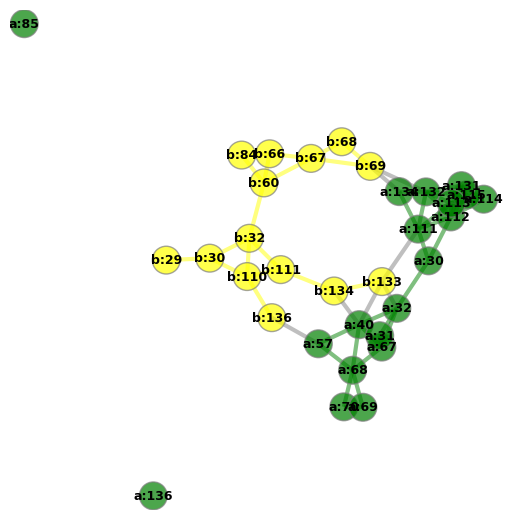

INFO:pyGeoMatchImm.data.datasets:

--------------------------------------------------Channel pMHC--------------------------------------------------


INFO:pyGeoMatchImm.data.datasets:  Node C:GLY:6: {'chain_id': 'C', 'residue_name': 'GLY', 'residue_number': 6, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 6.5755 , -0.27275, 21.251  ], dtype=float32), 'b_factor': 65.70999908447266, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'hbond_donors': array([0]), 'hbond_acceptors': array([0]), 'rsa': 0.5, 'atchley': tensor([-0.3840,  1.6520,  1.3300,  1.0450,  2.0640])}
INFO:pyGeoMatchImm.data.datasets:  Node C:VAL:7: {'chain_id': 'C', 'residue_name': 'VAL', 'residue_number': 7, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 9.918143 ,  1.3549999, 21.179998 ], dtype=float32), 'b_factor': 60.20000076293945, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'hbond_donors': array([0]), '

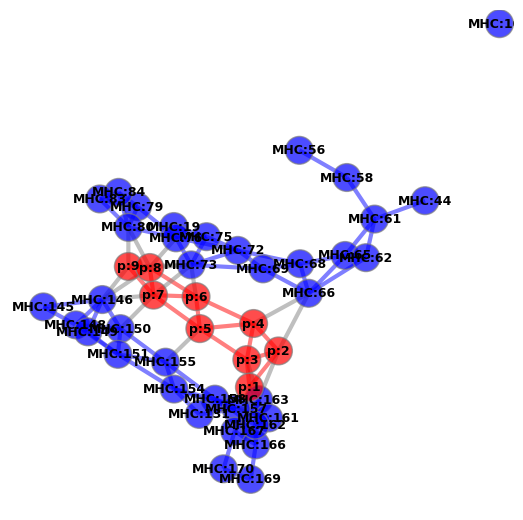

Channel: TCR
(resid E:THR:67 and chain {'chain_id': 'yellow', 'residue_name': 'THR', 'residue_number': 67, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 14.761572, -15.575857,  14.091857], dtype=float32), 'b_factor': 31.90999984741211, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 'hbond_donors': array([1]), 'hbond_acceptors': array([1]), 'rsa': 0.6126760563380281, 'atchley': tensor([-0.0320,  0.3260,  2.2130,  0.9080,  1.3130]), 'label': 'b:67'}) (resid D:ARG:57 and chain {'chain_id': 'green', 'residue_name': 'ARG', 'residue_number': 57, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 8.854909 ,  9.208909 , 10.6893635], dtype=float32), 'b_factor': 22.68000030517578, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), 'hbond_donors': array([1]), 'hbond_acceptors': array([0]), 'rsa': 0.2701612903225806, 'atchley': tensor([ 1.5380, -0.0550,  1.5020,  0.4400,  2.8970]), 'label': '

In [25]:
print(channels.ids)
dataset.show_graph(channels.ids[0])

In [ ]:

cv = CrossValidator(model_class=model_class,
                    dataset=ds, 
                    device=device,
                    peptides=peptides,
                    configs=config)

cv.run()


json.dump(config, open(f"./{save_dir}/config.json", "w"), indent=4)

plot_precision_recall_curve(cv.raw_results['labels'], 
                            cv.raw_results['predictions'], 
                            save_dir)

plot_roc_curve(cv.raw_results['labels'],
                cv.raw_results['predictions'],
                save_dir)

plot_loss_curve_logocv(cv.losses, save_dir=save_dir)

# reset pytorch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# clean cache, memory release
del channels
del ds
del cv
